### Projeto Final - DEEP LEARNING - UNISINOS - 06-2020
***
**<center><font size=5>Problema: Classificação de Tumores Cerebrais</font></center>**
***
**Nome**: MARCIO DE LIMA
***
Esse projeto contempla o desenvolvimento e a construção de 2 algoritmos para a classificação de tumores cerebrais através de imagens.

## Introdução e Objetivo

   O tumor cerebral é uma das mais agressivas doenças em crianças, jovens e adultos. Os tumores cerebrais representam de 85 a 90% de todos os tumores primários diagnosticados no Sistema Nervoso Central (SNC). Todos os anos, cerca de 11.700 pessoas são diagnosticadas com um tumor no cérebro, a taxa de sobrevida em cinco anos é de aproximadamente 34% para homens e 36% para mulheres. 

Os tumores cerebrais são classificados como: Tumor benigno, Tumor maligno, Tumor hipofisário, etc. A melhor técnica para detectar tumores cerebrais é a ressonância magnética (RM). 

Uma enorme quantidade de dados em imagens são geradas através das digitalizações. Essas imagens são examinadas pelo médico especializado. 

Um exame manual está sujeito a erros humanos no diagnóstico devido ao nível de complexidades envolvidas nos tumores cerebrais e em suas propriedades. Desta forma, a aplicação de técnicas de classificação usando Machine Learning (ML) e Deep Learning (Redes CNN) pode ser adotada e ajudar no diagnóstico. Essa aplicação tem mostrado consistentemente maior precisão do que a classificação manual. 


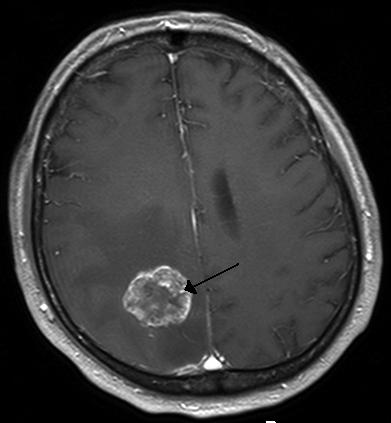

In [32]:
display(Image.open('tumor.jpg'))

### Origem dos Dados - DataSet

Esse dataset pode ser encontrado no Kaggle no endereço: 

https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

### Informações sobre o DataSet

Este dataset contém imagens cerebrais de seres humanos no formato de JPG (MRI scan) categorizadas em 2 classes binárias:

* `NO` - não temos um tumor. Também informado como `0`; 
* `YES` - tumor encontrado. Também informado como `1`.

Não há maiores informações sobre a origem dessas imagens no Kaggle. 

O dataset contém 155 imagens com tumores e 98 imagens sem tumores. Desta forma, o dataset encontrasse balanceado. Os arquivos de imagens estão separados em diferentes diretórios (no e yes), desta forma, o diretório representa seu label e target de identificação da resposta. O dataset apresenta base histórica, portanto nossos algoritmos serão do tipo de <b>aprendizado supervisionado de classificação binária</b>.

As imagens estão no formato JPG, mas estão em formato de pixels diferentes, variando de 200 pixels a 380 pixels de algura e largura. Estão em formato preto e branco com 8 bits. Os arquivos são datados no ano de 2019. 

### Importando as bibliotecas

In [1]:
# Instalação de pacotes necessários, caso necessite. 
#!pip install imutils
#!pip install opencv-python
#!pip install Pillow
#!pip install tensorflow
#!pip install keras
#!pip install xgboost

import os
import numpy as np 
import pandas as pd
import math
from PIL import Image
import time

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from keras.regularizers import l2
from keras.layers.advanced_activations import PReLU

import itertools
import cv2

Using TensorFlow backend.


In [2]:
os.listdir('dataset')

['no', 'yes']

### Pre-processamento

Existem várias formas de tratar os arquivos, eu escolhi devido a facilidade e meu conhecimento prévio de juntar os arquivos e seus labels para dividir melhor os dados para treino e teste futuro. 

#### Os arquivos serão lidos e importados com tamanho 128 x 128 pixels. Esse resizing tem o objetivo de padronizar os arquivos para o mesmo tamanho em pixels para a correta aprendizagem dos modelos e para ter mais performance no modelo.

As imagens do MRI já estão no padrão de cor correto, desta forma, não houve necessidade de transformar => 8-bit pixels, black and white

#### Utilização da técnica de Normalização, deixando todos os valores no intervalo entre 0 e 1. Desta forma, ganhamos performance no treinamento da rede neural e aumentamos a acurária.

In [3]:
X_data = []
Y_data = []
caminho_yes = 'dataset/yes'
caminho_no = 'dataset/no'
tamanho = (128, 128)
seed = 1313

# Juntando as imagens
for file in os.listdir(caminho_yes):
    image = cv2.imread(caminho_yes+'/'+file)
    image = cv2.resize(image,dsize=tamanho)
    # Normalizando a imagem (cores)
    image = image / 255.
    X_data.append(image)
    Y_data.append(1)

for file in os.listdir(caminho_no):
    image = cv2.imread(caminho_no+'/'+file)
    image = cv2.resize(image,dsize=tamanho)
    # Normalizando a imagem (cores)
    image = image / 255.
    X_data.append(image)
    Y_data.append(0)


In [4]:
X = np.array(X_data)
y = np.array(Y_data)
    
# Shuffle os arquivos
X, y = shuffle(X, y)
    
print(f'Total: {len(X)}')
print(f'X tamanho: {X.shape}')
print(f'y tamanho: {y.shape}')

Total: 253
X tamanho: (253, 128, 128, 3)
y tamanho: (253,)


In [5]:
# Formato de Cor dos arquivos - Estão em formato preto e branco com 8 bits.
Image.open(caminho_yes+'/'+'Y12.jpg').mode

'L'

## Criando os modelos

Para este trabalho escolhi o <b>SVC</b>, <b>XGBoost</b> e <b>Redes Neurais com o Keras</b>. 

Escolhido o método de Cross-Validation para os treinamentos dos modelos. O Cross Validation é uma técnica que pode ser utilizada para avaliar a performance de um modelo com menos variância que a técnica de dividir os dados em treino/teste. Confome estudo em Kuliahkomputer (2018), com esta técnica dividimos os dados em partes normalmente chamadas de k-folds (por exemplo k = 5, k = 10). Cada parte é chamada de fold. Cada fold é usado no treinamento de forma repetida e um fold por vez. Após executar o processo em k-1 folds, podemos sumarizar a performance em cada fold usando a média e o desvio padrão. O resultado é normalmente mais confiável e oferece maior acurácia ao modelo (Kuliahkomputer, 2018).


Os modelos XGBoost e SVC foram definidos com hiper-parâmetros em seu default pois são a primeira versão de modelo. 


In [6]:
#Criando e compilando a Rede Neural CNN - Keras
def build_model():
    model_cnn = Sequential()
    model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X.shape[1],X.shape[2],X.shape[3])))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.3))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(units=1, activation='sigmoid'))
    model_cnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model_cnn

### Arquitetura da Rede Neural

In [7]:
# Arquitetura da Rede Neural - Versão Inicial
build_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

As funções de otimização, erro e de ativação da última camada (saída) foram escolhidas devido ao caso de uso (Classificação binária (1 saída)). Se o caso de uso fosse de Multi-Classes seriam escolhidos outros parâmetros. 

Utilizado o Dropout para evitar o overfitting, usando 1 de 30% na primeira vez e 1 mais rígido de 50% no final.

Utilizado o kernel_size de 3 x 3 pixel como tamanho da janela de filtro da Conv2D. 

Escolhida a função de ativação RELU devido ser a mais utilizada e comum para a grande maioria dos casos de uso. 

As camadas de filtro iniciam em 32 (definido como padrão inicial) e dobram de valor a cada camada, indo pra 64 e depois 128. Foi utilizado filtro de 32 devido a importância do caso de uso em ter a maior acurária possível, pois tratasse de diagnóstico de saúde humana. 

Escolhido o algoritmo de otimização Root Mean Square Propogation (RMSProp) proposto por Geoffrey Hinton. Esse otimizador busca atenuar as oscilações verticais e elimina a necessidade de ajustar a taxa de aprendizado.

Escolhido a técnica de Max pooling para redução de dimensionalidade a cada camada, essa técnica extrai os valores mais altos de cada janela (window). O Max pooling a cada camada proporciona melhor desempenho no treinamento do modelo.


In [8]:
#Função utilitaria
# Definindo os valores para o número de folds
num_folds = 10

#Cross-Validation de Redes Neurais
def k_fold_train(model, x_train, y_train):
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    k_fold_accuracies = []

    for k_train, k_test in kfold.split(x_train,y_train):
        history = model.fit(
            x_train[k_train],
            y_train[k_train],
            epochs=10,
            batch_size=20,
            verbose=0,
            validation_data=(x_train[k_test], y_train[k_test]))

        #Acuraria
        score = history.history['val_accuracy']
        k_fold_accuracies.append(score)

    return k_fold_accuracies


In [9]:
# Avaliação dos modelos e Considerações
def montarBoxPlot(resultados, nomes):

    sns.boxplot( y=nomes, x=resultados);
    plt.title('Comparação entre os Algoritmos')
    plt.show()  

In [10]:
# Função utilitária
def montarMatrixConfusion(y_test, y_pred, title): 
    
    cm = confusion_matrix(y_test, y_pred)
    print("\n Tabela - %s" % title)
    print(cm)
    print("\n")
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.title(title)
    plt.show()


In [11]:
# Função utilitária para executar os modelos de forma genérica
def executar(X, X_flat, Y, titulo): 
    modelos = []
    modelos.append(('SVC', SVC(probability=True)))
    modelos.append(('XGB', XGBClassifier(n_estimators=100)))
    modelos.append(('CNN', build_model()))

    # Avaliando cada modelo e exibindo os resultados
    resultados = []
    nomes = []

    kfold = KFold(n_splits = num_folds, random_state = seed, shuffle=True)

    for nome, modelo in modelos:
        t1 = time.time()
        if nome != 'CNN': 

            cv_results = cross_val_predict(modelo, X_flat, Y, cv = kfold)
            cv_results_score = cross_val_score(modelo, X_flat, Y, cv = kfold, scoring = 'accuracy')

            #Confusion Matrix
            montarMatrixConfusion(Y, cv_results, titulo + " - Confusion Matrix - Modelo %s\n\n" % nome)
            msg = "Modelo: %s => %.2f%s (Acuraria) - %s" % (nome, cv_results_score.mean() * 100, '%', titulo)

            resultados.append(cv_results_score)
            nomes.append(nome)
        
        else:
            mean_acc = k_fold_train(modelo, X, Y)
            msg = "Modelo: %s => %.2f%s (Acuraria) - %s" % (nome, np.mean(mean_acc) * 100, '%', titulo)

            resultados.append(np.array(mean_acc[5]))
            nomes.append(nome)

        print("\n")
        print(msg)
        tempoExec = time.time() - t1
        print("Tempo de execução do modelo: {} segundos".format(round(tempoExec)))

    print("\n")
    print("\n")
    montarBoxPlot(resultados, nomes)
    return resultados

In [12]:
# Flattern das Imagens, o X está com 4 dimensões, precisa ser 2
X_flat = X.reshape(X.shape[0],X.shape[1]*X.shape[2]*X.shape[3])
X_flat.shape

(253, 49152)


 Tabela - Modelos utilizados - Confusion Matrix - Modelo SVC


[[ 28  70]
 [  4 151]]




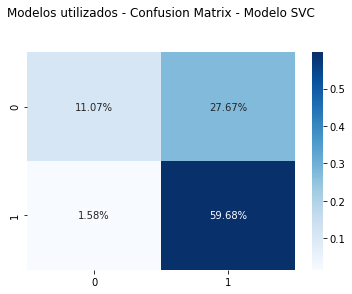



Modelo: SVC => 70.68% (Acuraria) - Modelos utilizados
Tempo de execução do modelo: 308 segundos

 Tabela - Modelos utilizados - Confusion Matrix - Modelo XGB


[[ 74  24]
 [ 13 142]]




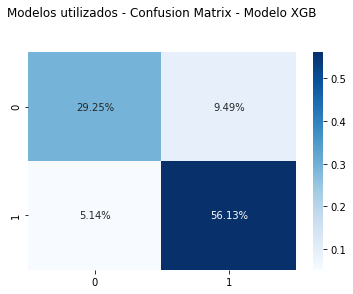



Modelo: XGB => 85.35% (Acuraria) - Modelos utilizados
Tempo de execução do modelo: 1033 segundos


Modelo: CNN => 98.35% (Acuraria) - Modelos utilizados
Tempo de execução do modelo: 284 segundos






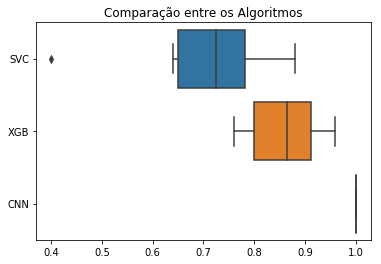

In [13]:
resultados = executar(X, X_flat, y, 'Modelos utilizados')

## Modelo Escolhido => CNN com melhor acurária de 98% e tempo de treinamento (média) de 300 segundos

### Otimizando o Modelo para aumentar a acurácia. 

In [14]:
# Essa célula de fontes e funções tem o objetivo de escolher os melhores parâmetros para nossa rede neural.
# Os parâmetros são sugeridos e podem ser modificados para novos testes. 
# Como melhoria futura, poderiamos ter implementado essa busca pelo RandomizedSearchCV 
# assim como fazemos com algoritmos de ML.
#    Reference
#    ---------
#    https://keras.io/scikit-learn-api/

def build_model_cnn(camadas=[32,64,128], tamanho=(128,128,3), activate='relu', drop=0.5, var_optimizer='adam', l2_penalty=0.01):
    model_cnn = Sequential()
    model_cnn.add(Conv2D(camadas[0], kernel_size=(3, 3), activation=activate, input_shape=tamanho, kernel_regularizer = l2(l2_penalty)))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Conv2D(camadas[1], kernel_size=(3, 3), activation=activate, kernel_regularizer = l2(l2_penalty)))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(drop/2))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(camadas[2], activation=activate, kernel_regularizer = l2(l2_penalty)))
    model_cnn.add(Dropout(drop))
    model_cnn.add(Dense(units=1, activation='sigmoid'))
    model_cnn.compile(optimizer=var_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model_cnn
    

# Função utilitária para executar os modelos de forma genérica com 7 combinações diferentes
def executarOtimizacao(X, X_flat, Y): 
    modelos = []
    tamanho = (X.shape[1],X.shape[2],X.shape[3])
    modelos.append(('CNN-0', build_model_cnn()))
    modelos.append(('CNN-1', build_model_cnn([64,64,128], tamanho,'relu',0.5,'adam',0.05)))
    modelos.append(('CNN-2', build_model_cnn([32,64,64], tamanho,'relu',0.5,'rmsprop',0.1)))
    modelos.append(('CNN-3', build_model_cnn([8,16,32], tamanho,'selu', 0.5,'rmsprop')))
    modelos.append(('CNN-4', build_model_cnn([16,16,32], tamanho,'relu',0.4)))
    modelos.append(('CNN-5', build_model_cnn([16,32,64], tamanho,'relu',0.4,'rmsprop')))
    modelos.append(('CNN-6', build_model_cnn([64,128,256], tamanho,'relu',0.5,'rmsprop')))

    # Avaliando cada modelo e exibindo os resultados
    kfold = KFold(n_splits = num_folds, random_state = seed, shuffle=True)

    for nome, modelo in modelos:
        t1 = time.time()
        mean_acc = k_fold_train(modelo, X, Y)
        msg = "Modelo: %s => %.2f%s (Acuraria)" % (nome, np.mean(mean_acc) * 100, '%')
        print(msg)
        tempoExec = time.time() - t1
        print("Tempo de execução do modelo: {} segundos".format(round(tempoExec)))
        print("\n")
    print("\n")

In [15]:
resultados_otimizacao = executarOtimizacao(X, X_flat, y)

Modelo: CNN-0 => 92.90% (Acuraria)
Tempo de execução do modelo: 319 segundos


Modelo: CNN-1 => 85.17% (Acuraria)
Tempo de execução do modelo: 486 segundos


Modelo: CNN-2 => 79.39% (Acuraria)
Tempo de execução do modelo: 269 segundos


Modelo: CNN-3 => 94.13% (Acuraria)
Tempo de execução do modelo: 141 segundos


Modelo: CNN-4 => 94.63% (Acuraria)
Tempo de execução do modelo: 122 segundos


Modelo: CNN-5 => 92.73% (Acuraria)
Tempo de execução do modelo: 146 segundos


Modelo: CNN-6 => 88.95% (Acuraria)
Tempo de execução do modelo: 992 segundos






## Avaliação Final do Trabalho

Abaixo, segue uma tabela comparativa do melhor modelo inicial com suas otimizações. 

|   <b>Nome do Modelo</b>  | <b>Acurácia</b> | <b>Tempo de Treinamento</b> |    <b>Camadas</b>   | <b>Ativador</b> | <b>Optimizador</b> |
|:-----------------:|:--------:|:--------------------:|:------------:|:--------:|:-----------:|
| CNN 1 Versão      |  <b>98,35%<b>  |     300 segundos     |  [32,64,128] |   relu   |   rmsprop   |
| CNN 0 - Otimizado |  92.90%  |     319 segundos     |  [32,64,128] |   relu   |   rmsprop   |
| CNN 1 - Otimizado |  85.17%  |     486 segundos     |  [64,64,128] |   relu   |     adam    |
| CNN 2 - Otimizado |  79.39%  |     269 segundos     |  [32,64,64]  |   relu   |   rmsprop   |
| CNN 3 - Otimizado |  94.13%  |     141 segundos     |   [8,16,32]  |   selu   |   rmsprop   |
| CNN 4 - Otimizado |  94.63%  |     122 segundos     |  [16,16,32]  |   relu   |   rmsprop   |
| CNN 5 - Otimizado |  92.73%  |     146 segundos     |  [16,32,64]  |   relu   |   rmsprop   |
| CNN 6 - Otimizado |  88.95%  |     992 segundos     | [64,128,256] |   relu   |   rmsprop   |

Conforme tabela acima, o melhor modelo continua sendo o modelo de CNN da primeira versão com 98,35% de acurácia. 

## Ambiente Utilizado

#### Para a implementação e execução dos algoritmos foi escolhido um ambiente local (Notebook Core I5, 16GB de RAM, placa de vídeo GFORCE - Nvidia) com Júpiter Notebooks e Python 3.7. 

In [31]:
# Versões das libs principais utilizadas
import platform
print("Python = " + platform.python_version())
print("Numpy = " + np.__version__)
print("Pandas = " + pd.__version__)
print("Seaborn = " + sns.__version__)
import matplotlib
print("Matplotlib = " + matplotlib.__version__)
import keras 
print("Keras = " + keras.__version__)
import tensorflow
print("TensorFlow = " + tensorflow.__version__)
import sklearn
print("Sklearn = " + sklearn.__version__)
import xgboost
print("XGBClassifier = " + xgboost.__version__)
print("Cv2 = " + cv2.__version__)

Python = 3.7.4
Numpy = 1.16.2
Pandas = 0.24.2
Seaborn = 0.9.0
Matplotlib = 3.0.3
Keras = 2.3.1
TensorFlow = 2.1.0
Sklearn = 0.21.3
XGBClassifier = 0.90
Cv2 = 4.2.0


### FIM
### OBRIGADO